# projeto

dataset saved at [dropbox](https://www.dropbox.com/home/wds23s4_bwl_chartformation_dataset)

# Library

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd

import zipfile
import py7zr
import os


# DATASET Hermaeus

data from [Hermeaus](https://github.com/Hermaeus1618/PatternRecognition)

... need to download by hand and unzip it! 

The usded file `"aaatemp/DATASET.zfs"` has been unziped already!

## Funs

### fun for extracting

In [57]:
def dataset_extract_from_zip(zip_path):
    """
    Extracts the dataset from a zip file and returns a DataFrame with the data.

    Data from https://github.com/Hermaeus1618/PatternRecognition
    
    Args:
        zip_path (str): Path to the zip file.
    
    Returns:
        pd.DataFrame: DataFrame containing the extracted data.
    """
    ZIP_PATH = zip_path


    if not os.path.exists(ZIP_PATH):
        raise FileNotFoundError(f"The file '{ZIP_PATH}' does not exist. Please check the file path.")


    data = []

    with zipfile.ZipFile(ZIP_PATH, "r") as zfile:
        # Ler todos os nomes de arquivos no ZIP
        filenames = [f.filename for f in zfile.infolist()]
    
        for fname in filenames:
            # Dividir o nome do arquivo em partes
            # Values are seprated by "_GAP_" string which can be easily converted back into list by pd.Series().str.split()
            # Naming convention for Numpy files: IOC_GAP_CupAndHandle_GAP_HOUR1_GAP_1722503700_GAP_1725272100 STOCK_GAP_PATTERN_GAP_TIMEFRAME_GAP_START_GAP_END
            parts = fname.split("_GAP_")
            if len(parts) != 5:
                print(f"Ignorando arquivo com formato inválido: {fname}")
                continue
            
            try:
                company, pattern, frequency, start, end = parts
                start = int(start)
                end = int(end)
            except ValueError as e:
                print(f"Erro ao converter start/end para inteiro no arquivo {fname}: {e}")
                continue
            
            # Ler os dados binários e convertê-los para um array Float64
            try:
                with zfile.open(fname) as file:
                    array = np.frombuffer(file.read(), dtype=np.float64)
                if array.size == 0:
                    print(f"Array vazio no arquivo {fname}. Ignorando.")
                    continue
            except Exception as e:
                print(f"Erro ao ler os dados binários do arquivo {fname}: {e}")
                continue
            
            # Adicionar os dados à lista
            data.append({
                "Company": company,
                "Pattern": pattern,
                "Frequency": frequency,
                "Start": start,
                "End": end,
                "Array": array
            })

    df = pd.DataFrame(data)

    return df

### fun for transformation

In [ ]:
def calculate_time_range(row):
    """
    It is a complement to the dataset_extract_from_zip() function, that extracts the a specific data from:
    https://github.com/Hermaeus1618/PatternRecognition

    It dependes on the frequency of the data to calculate the time range, based on the start and end timestamps.
    It is used to create the time range for the data in the DataFrame.

    Simple check as follow:
    print(df["Frequency"].unique()) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    ... where df is the DataFrame returned by dataset_extract_from_zip()
    
    Frequencies:
    - DAILY: Daily intervals
    - WEEKLY: Weekly intervals
    - MONTHLY: Monthly intervals
    - MIN5: 5-minute intervals
    - MIN15: 15-minute intervals

    Args:
        row (pd.Series): A row from the DataFrame.
    Returns:
        pd.DatetimeIndex: A DatetimeIndex object representing the time range.

    Example:
        df = dataset_extract_from_zip("path/to/your/file.zip")
        df["TimeRange"] = df.apply(calculate_time_range, axis=1)
        print(df[["Company", "Pattern", "Frequency", "TimeRange"]])
    """


    frequency = row["Frequency"]
    start = row["Start"]
    end = row["End"]

    # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    
    if frequency == "DAILY":        
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="D")
    
    elif frequency == "WEEKLY":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="W")
    
    elif frequency == "MONTHLY":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="M")

    elif frequency == "MIN5":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="5T")
    
    elif frequency == "MIN15":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="15T")
    elif frequency == "MIN30":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="30T")
    
    elif frequency == "HOUR1":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                            end=pd.to_datetime(end, unit="s"), 
                            freq="H")
    else:
        print(f"Unknown frequency: {frequency}")
        return None

In [62]:
def calculate_time_range_per_row(row):
    """
    It is a complement to the dataset_extract_from_zip() function, that extracts the a specific data from:
    https://github.com/Hermaeus1618/PatternRecognition

    It dependes on the frequency of the data to calculate the time range, based on the start and end timestamps.
    It is used to create the time range for the data in the DataFrame.

    Simple check as follow:
    print(df["Frequency"].unique()) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    ... where df is the DataFrame returned by dataset_extract_from_zip()
    
    Frequencies:
    - DAILY: Daily intervals
    - WEEKLY: Weekly intervals
    - MONTHLY: Monthly intervals
    - MIN5: 5-minute intervals
    - MIN15: 15-minute intervals

    Args:
        row (pd.Series): A row from the DataFrame.
    Returns:
        pd.DatetimeIndex: A DatetimeIndex object representing the time range.

    Example:
        df = dataset_extract_from_zip("path/to/your/file.zip")
        df["TimeRange"] = df.apply(calculate_time_range, axis=1)
        print(df[["Company", "Pattern", "Frequency", "TimeRange"]])
    """


    frequency = row["Frequency"]
    start = row["Start"]
    end = row["End"]

    try: # Validation
        start = int(start)
        end = int(end)        
        if start <= 0 or end <= 0 or start >= end:
            print(f"invalid values: start={start}, end={end}")
            return (None, None, None)           
    except ValueError as e:
        print(f"Error by convering start/end to int: {e}")
        return (None, None, None)
        
    start=pd.to_datetime(start, unit="s")
    end=pd.to_datetime(end, unit="s")    
    
    freq_map = {
    "DAILY": "D",
    "WEEKLY": "W",
    "MONTHLY": "ME",
    "MIN5": "5min",
    "MIN15": "15min",
    "MIN30": "30min",
    "HOUR1": "h"
    }

    freq = freq_map.get(frequency)
    
    if freq:
        range = pd.date_range(start=start, end=end, freq=freq)
        return (start, end, range)
    else:
        print(f"Unknown frequency: {frequency}")
        return (start, end, None)

In [71]:
def is_candlestick_viable(row):
    """
    Avalia se é viável gerar OHLC (candlestick) a partir dos dados de um registro.

    Condições:
    - Frequência precisa ser subdiária (MIN5, MIN15, MIN30, HOUR1)
    - TimeRange precisa conter pelo menos 2 pontos por dia útil

    Retorna:
    - True se for possível gerar OHLC válido
    - False caso contrário
    """
    frequency = row.get("Frequency")
    time_range = row.get("TimeRange")

    if time_range is None or not isinstance(time_range, pd.DatetimeIndex):
        return False

    # Frequências subdiárias
    subdaily = ["MIN5", "MIN15", "MIN30", "HOUR1"]
    if frequency not in subdaily:
        return False

    # Contagem de pontos por dia
    counts_per_day = pd.Series(time_range).groupby(lambda x: x.date()).count()

    # Verifica se há pelo menos 2 pontos por dia (mínimo para OHLC)
    return counts_per_day.ge(2).any()


In [ ]:
def array_per_row_normalization(row):
    """
    
    """
    array = row.get("Array")
    
    if array is None or not isinstance(array, np.ndarray):
        return None

    # Normalização
    min_val = np.min(array)
    max_val = np.max(array)
    
    if max_val == min_val:
        return None  # Evita divisão por zero
    
    normalized_array = (array - min_val) / (max_val - min_val)
    
    return normalized_array 

### fun for ploting

In [78]:
def plot_and_save_by_pattern_from_zipfile(zip_path, pattern_name, max_plots=None, dropbox_folder=None):
    """
    Extrahiert und speichert alle Plots für ein bestimmtes Muster aus einer ZIP-Datei.
    :param zip_path: Pfad zur ZIP-Datei
    :param pattern_name: Name des Musters, das extrahiert werden soll
    :param max_plots: Maximale Anzahl der Plots, die gespeichert werden sollen (None für alle)
    :param dropbox_folder: Zielordner für die gespeicherten Plots (None für aktuellen Ordner)

    Example:
    # Plots für die ersten 10 Dateien erstellen
        dataset_path_dropbox = r"C:\\Users\\...\\Dropbox\\wds23s4_bwl_chartformation_dataset"
        plot_and_save_all_by_pattern(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)
    """

    # Zielordner erstellen
    if dropbox_folder is not None:
        dataset_folder = os.path.join(dropbox_folder, pattern_name)
    
    os.makedirs(dataset_folder, exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zfile:
        # Dateinamen und Metadaten extrahieren
        files = pd.Series([f.filename for f in zfile.infolist()])
        meta_df = files.str.split("_GAP_", expand=True)
        meta_df.columns = ["ticker", "pattern", "freq", "start_ts", "end_ts"]
        meta_df["filename"] = files

        # Filter auf gewünschtes Pattern
        subset = meta_df[meta_df["pattern"] == pattern_name]

        # Begrenzung der Anzahl der Plots
        if max_plots is not None:
            subset = subset.head(max_plots)

        for i, row in subset.iterrows():
            file = row["filename"]
            ticker = row["ticker"]
            try:
                with zfile.open(file) as f:
                    data = np.frombuffer(f.read(), dtype=np.float64)

                # Plot erstellen
                plt.figure(figsize=(8, 3))
                plt.plot(data, color="black")  # Linie in Schwarz
                plt.axis("off")  # Achsen ausblenden
                plt.tight_layout()

                # Dateiname sichern
                safe_ticker = ticker.replace("/", "_")
                filename = os.path.join(dataset_folder, f"{i:03d}_{safe_ticker}.png")
                plt.savefig(filename, bbox_inches="tight", pad_inches=0)
                plt.close()

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {file}: {e}")



In [89]:
def plot_and_save_by_pattern_from_df(df, pattern_name, max_plots=None, dropbox_folder=None, img_size=(224, 224), dpi=100):
    """
    Extraction and saving of all plots for a specific pattern from a Pandas DataFrame.
  
    The image are prepared to CNN models keeping the aspect ratio of 1:1 and the size of 224x224 pixels, it helps to train the model afterwards.
    The images are saved in the format: {i:04d}_{ticker}.png per folder {pattern_name}.

    Drobox folder is used to save the images, and share the results with the team.

    This function follows some key points for CNN models:
        * Always use fixed size images
        * Normalize either during image generation or via preprocessing layer. Use the `Array_norm` instead of Array!
        * Balance the number of samples per class (1:1 ratio) to avoid class bias
        * Save datasets in folder structure: dataset/ClassName/*.png
        * Start simple (e.g., black line on white background) before moving to complex inputs

    Args:
        :param df: Data Frame mit den Spalten "Pattern", "Array_norm", "Company"
        :param img_size: Größe der Bilder in Pixeln (z.B. 224x224).
        :param dpi: Auflösung der Bilder 
        :param pattern_name: Name des Musters, das extrahiert werden soll
        :param max_plots: Maximale Anzahl der Plots, die gespeichert werden sollen (None für alle)
        :param dropbox_folder: Zielordner für die gespeicherten Plots (None für aktuellen Ordner)

    Example:
    # Plots für die ersten 10 Dateien erstellen
    dataset_path_dropbox = "C:.../Dropbox/wds23s4_bwl_chartformation_dataset"
    plot_and_save_all_by_pattern(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

    """
    if dropbox_folder is not None:
        dataset_folder = os.path.join(dropbox_folder, pattern_name)
        os.makedirs(dataset_folder, exist_ok=True)
    else:
        dataset_folder = os.getcwd()

    subset = df[df["Pattern"] == pattern_name]
    if max_plots is not None:
        subset = subset.head(max_plots)

    for i, row in subset.iterrows():
        ticker = str(row['Company'])
        data = row["Array_norm"]

        fig = plt.figure(figsize=(img_size[0]/dpi, img_size[1]/dpi), dpi=dpi)
        plt.plot(data, color="black", linewidth=2)
        plt.axis("off")
        plt.tight_layout(pad=0)

        filename = os.path.join(dataset_folder, f"{i:04d}_{ticker}.png")
        plt.savefig(filename, bbox_inches="tight", pad_inches=0)
        plt.close(fig)


In [87]:
def plot_and_save_by_pattern_from_df_old(df, pattern_name, max_plots=None, dropbox_folder=None):
    """
    Extrahiert und speichert alle Plots für ein bestimmtes Muster aus einer ZIP-Datei.
    :param zip_path: Pfad zur ZIP-Datei
    :param pattern_name: Name des Musters, das extrahiert werden soll
    :param max_plots: Maximale Anzahl der Plots, die gespeichert werden sollen (None für alle)
    :param dropbox_folder: Zielordner für die gespeicherten Plots (None für aktuellen Ordner)

    Example:
    # Plots für die ersten 10 Dateien erstellen
    dataset_path_dropbox = "C:.../Dropbox/wds23s4_bwl_chartformation_dataset"
    plot_and_save_all_by_pattern(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

    """

    # Zielordner erstellen
    if dropbox_folder is not None:
        dataset_folder = os.path.join(dropbox_folder, pattern_name)
    
    os.makedirs(dataset_folder, exist_ok=True)

    # Filter auf gewünschtes Pattern
    subset = df[df["Pattern"] == pattern_name]

    # Begrenzung der Anzahl der Plots
    if max_plots is not None:
        subset = subset.head(max_plots)   
    


    for i, row in subset.iterrows():
        ticker = row['Company']
        #df["Array"] = df["Array"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
        data = row["Array"]

        # Plot erstellen
        plt.figure(figsize=(8, 3))
        plt.plot(data, color="black")  # Linie in Schwarz
        plt.axis("off")  # Achsen ausblenden
        plt.tight_layout()

        # Dateiname sichern
        safe_ticker = ticker.replace("/", "_")
        filename = os.path.join(dataset_folder, f"{i:03d}_{safe_ticker}.png")
        plt.savefig(filename, bbox_inches="tight", pad_inches=0)
        plt.close()



#### OHLC + Candlestick 

[not implmented yet] ... only to remember the function 

In [ ]:
# Ensure the index is a DatetimeIndex
df = df.set_index("Start")

# Filter rows where the "Array" column has exactly 4 elements (OHLC data)
df = df[df["Array"].apply(lambda x: len(x) == 4)]

# Extract the required columns for candlestick plotting
# Assuming the "Array" column contains OHLC data in the order [Open, High, Low, Close]
ohlc_data = pd.DataFrame(df["Array"].tolist(), index=df.index, columns=["Open", "High", "Low", "Close"])

# Plot the data
mpf.plot(
    ohlc_data[-50:], 
    type='candle', 
    style='charles', 
    figsize=(3, 3),
    axisoff=True,
    savefig='images/DoubleTop/sample_001.png'
)

## DATA

#### data frame complete (raw)

In [94]:
dataset01_path_zip = "aaatemp/DATASET.zfs"
dataset01_df = dataset_extract_from_zip(dataset01_path_zip)

start_list, end_list, time_range_list = [], [], []
for index, row in dataset01_df.iterrows():
    start, end, time_range = calculate_time_range_per_row(row)
    start_list.append(start)
    end_list.append(end)
    time_range_list.append(time_range)

dataset01_df["StartDate"] = start_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["EndDate"] = end_list #pd.to_datetime(dataset01_df["End"], unit="s")
dataset01_df["TimeRange"] = time_range_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["Array_norm"] = dataset01_df["Array"].apply(lambda x: x/np.mean(x) if isinstance(x, np.ndarray) else x)
dataset01_df["ArrayLength"] = dataset01_df["Array"].apply(len)

discrepancies = dataset01_df[dataset01_df["ArrayLength"] != dataset01_df["TimeRange"].apply(len)]
if not discrepancies.empty:
    print("Discrepâncias encontradas entre ArrayLength e TimeRange:")
    print(discrepancies[["Company", "Pattern", "ArrayLength", "TimeRange"]])

print(dataset01_df.shape)
print(dataset01_df.head())

Discrepâncias encontradas entre ArrayLength e TimeRange:
          Company            Pattern  ArrayLength  \
0       AXISCADES  AscendingTriangle           82   
1        BOSCHLTD  AscendingTriangle           18   
2       CELLPOINT  AscendingTriangle            9   
3          CHAVDA  AscendingTriangle          114   
4            DHTL  AscendingTriangle           17   
...           ...                ...          ...   
59027        LTIM  DoubleTopInitiate           56   
59028   MAXHEALTH  DoubleTopInitiate           15   
59029         ACC        RoundingTop           14   
59030  ADANIENSOL        RoundingTop           21   
59031  APOLLOHOSP        RoundingTop           15   

                                               TimeRange  
0      DatetimeIndex(['2024-05-02', '2024-05-03', '20...  
1      DatetimeIndex(['2024-08-06', '2024-08-07', '20...  
2      DatetimeIndex(['2024-08-20', '2024-08-21', '20...  
3      DatetimeIndex(['2024-03-13', '2024-03-14', '20...  
4      Date

In [91]:
print(dataset01_df.groupby(["Pattern"]).size().sort_values(ascending=False)) 




Pattern
RectangleChannel                   3157
DescendingChannel                  2979
RoundingTop                        2889
RoundingBottom                     2862
AscendingTriangle                  2500
DoubleTopPotential                 2500
DoubleBottomInitiate               2441
DescendingTriangle                 2439
DoubleTopInitiate                  2431
DoubleBottomPotential              2425
RectangleChannelPotential          2353
SymmetricTriangle                  2161
AscendingChannelBD                 2027
DoubleBottom                       1907
DoubleTop                          1894
HeadAndShoulder                    1646
RectangleChannelBO                 1639
RectangleChannelBD                 1636
SymmetricTriangleBO                1631
AscendingTriangleBD                1538
DescendingChannelBD                1325
DescendingTriangleBD               1267
BullishFlag                        1251
ReverseHeadAndShoulder             1247
AscendingChannelBO              

In [95]:
print(dataset01_df.groupby(["Frequency"]).size().sort_values(ascending=False)) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']

Frequency
HOUR1      13419
MIN30      12884
MIN15      11348
MIN5        9370
DAILY       7611
WEEKLY      3151
MONTHLY     1249
dtype: int64


<Axes: >

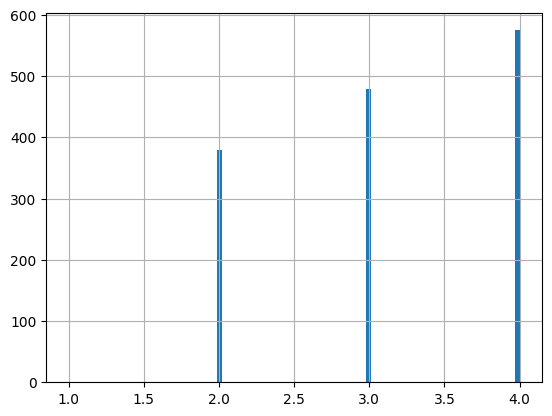

In [103]:
dataset01_df.loc[dataset01_df["ArrayLength"] < 5, "ArrayLength"].hist(bins=100)

  

In [ ]:
# dataset01_df["IsCandlePossible"] = dataset01_df.apply(is_candlestick_viable, axis=1)


#### Header and Shoulder (HAS)

In [104]:
dataset01_df_has = dataset01_df.copy()
dataset01_df_has = dataset01_df_has[dataset01_df_has["Pattern"].str.contains("HeadAndShoulder")]
dataset01_df_has = dataset01_df_has[dataset01_df_has["ArrayLength"] > 3]
print(dataset01_df_has.shape)
print(dataset01_df_has.groupby(["Pattern"]).size().sort_values(ascending=False))

(4186, 11)
Pattern
HeadAndShoulder                    1620
ReverseHeadAndShoulder             1230
HeadAndShoulderPotential            828
ReverseHeadAndShoulderPotential     508
dtype: int64


### PLOT+SAVE

plot_and_save_by_pattern_from_zipfile()
plot_and_save_by_pattern_from_df()

In [ ]:
# Plots für die ersten 10 Dateien erstellen
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"
plot_and_save_by_pattern_from_zipfile(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

In [80]:
# Plots für die ersten 10 Dateien erstellen
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"

# Call the function with the updated DataFrame
plot_and_save_by_pattern_from_df(dataset01_df, "TripleTop", max_plots=10, dropbox_folder=dataset_path_dropbox)

#### HAS

In [ ]:
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"

for pattern in dataset01_df_has["Pattern"].unique():
    print(f"Processing pattern: {pattern}")
    plot_and_save_by_pattern_from_df(dataset01_df_has, pattern, max_plots=508, dropbox_folder=dataset_path_dropbox)


Processing pattern: ReverseHeadAndShoulder
Processing pattern: ReverseHeadAndShoulderPotential
Processing pattern: HeadAndShoulder
Processing pattern: HeadAndShoulderPotential
